# Exercises

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import code.utilities as util

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

In [71]:
def fit_linear(**kwargs):
    K, S, ks, rate = util.generate_data_linear(**kwargs)

    K_flat = K.ravel()

    K_hat = (np.linalg.pinv(S.T @ S) @ (S.T @ rate))[:-1]

    correlation = (K_flat.T @ K_hat) / (np.linalg.norm(K_flat, 2) * np.linalg.norm(K_hat, 2))

    return correlation

Text(0, 0.5, 'Average correlation')

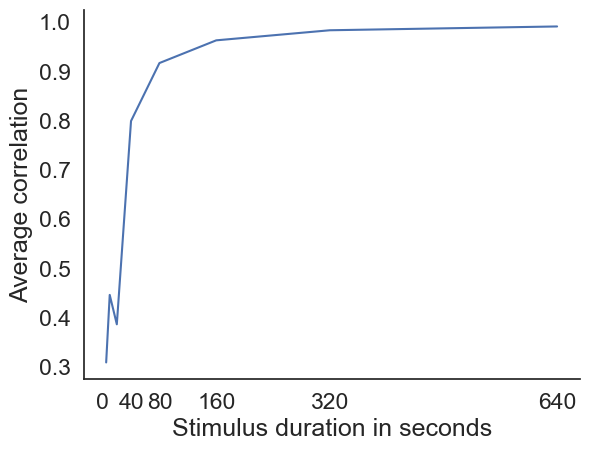

In [72]:
durations = [5., 10., 20., 40., 80., 160., 320., 640.]
n = 10 # Number of runs per duration

correlations = np.array([[fit_linear(duration=duration) for _ in range(n)] for duration in durations])
avg_correlations = np.mean(correlations, axis=1)

plt.plot(durations, avg_correlations)
plt.xlabel('Stimulus duration in seconds')
plt.xticks([0, 40, 80, 160, 320, 640])
plt.ylabel('Average correlation')

As is clear from the plot above, an increased stimulus duration leads to increased correlation between the actual and the estimated receptive field. This means that the estimator becomes more accurate the longer stimulus is. At lower stimulus durations, this effect may not be visible due to the greater impact of noise. The accuracy increase flattens off significantly after a stimulus duration of 80 seconds, and barely increases beyond 160 seconds. Therefore, in practical scenarios where processing time is relevant, it may not be necessary to increase the stimulus duration much further.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

Text(0, 0.5, 'Average correlation')

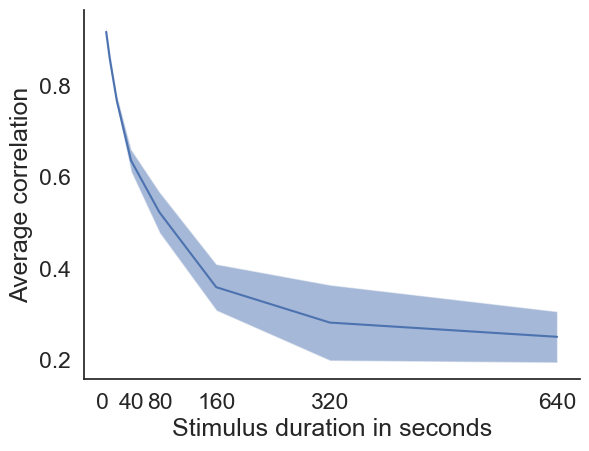

In [73]:
noise_variances = [5., 10., 20., 40., 80., 160., 320., 640.]
n = 10 # Number of runs per duration

correlations = np.array([[fit_linear(duration=100, noise_variance=noise_variance) for _ in range(n)] for noise_variance in noise_variances])
avg_correlations = np.mean(correlations, axis=1)
correlation_stds = np.std(correlations, axis=1)

plt.plot(durations, avg_correlations)
plt.fill_between(durations, avg_correlations + correlation_stds, avg_correlations - correlation_stds, alpha=0.5)
plt.xlabel('Stimulus duration in seconds')
plt.xticks([0, 40, 80, 160, 320, 640])
plt.ylabel('Average correlation')

As expected, the plot above show that the average correlation and thus the estimator accuracy decreases when the noise variance increases. Due to greater noise variance, the standard deviation of correlation between runs also increases.

## Exercise 3
---
What happens if the neural response is related to the filtered stimulus by a nonlinear function  $r = f_\mathrm{nonlinear}(\mathbf{k}^T \mathbf{s})$, e.g., by setting the `f_nonlin` argument in the data generation function to `f_threshold_quadratic` in excercise 1? Why does the linear estimator still provide a reliable estimate of the true RF? What happens if you use a full quadratic nonlinearity and set the `offset` term to 0? For more details, see Sharpee Ann Rev Neurosci (2013) (link in "Background" section).

Text(0, 0.5, 'Average correlation')

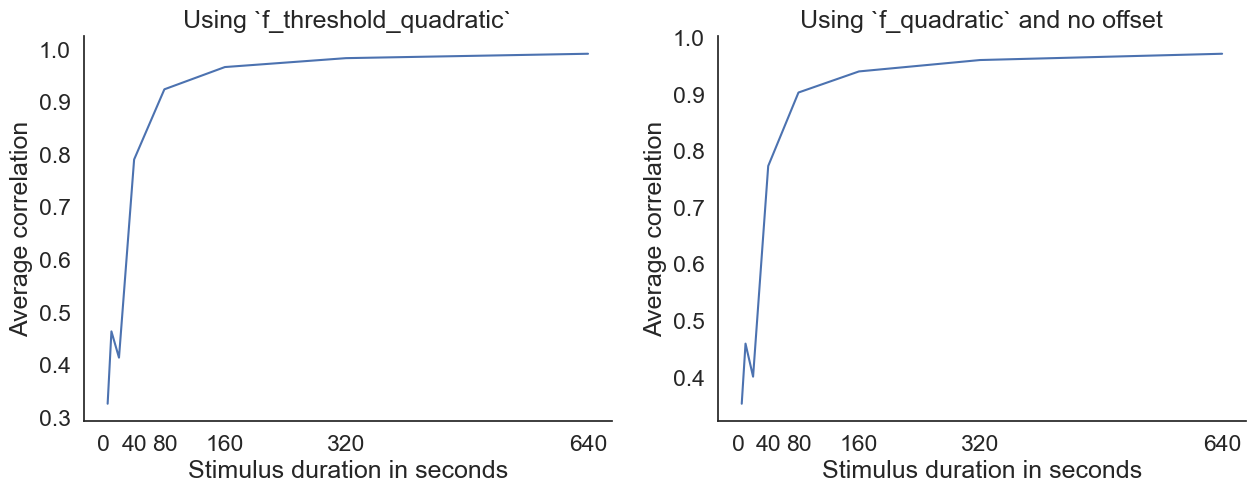

In [74]:
durations = [5., 10., 20., 40., 80., 160., 320., 640.]
n = 10 # Number of runs per duration

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# f_threshold_quadratic
correlations = np.array([[fit_linear(duration=duration, f_nonlin=util.f_threshold_quadratic) for _ in range(n)] for duration in durations])
avg_correlations = np.mean(correlations, axis=1)

axs[0].plot(durations, avg_correlations)
axs[0].set_title('Using `f_threshold_quadratic`')
axs[0].set_xlabel('Stimulus duration in seconds')
axs[0].set_xticks([0, 40, 80, 160, 320, 640])
axs[0].set_ylabel('Average correlation')

# f_quadratic
correlations = np.array([[fit_glm(duration=duration, f_nonlin=util.f_quadratic) for _ in range(n)] for duration in durations])
avg_correlations = np.mean(correlations, axis=1)

axs[1].plot(durations, avg_correlations)
axs[1].set_title('Using `f_quadratic` and no offset')
axs[1].set_xlabel('Stimulus duration in seconds')
axs[1].set_xticks([0, 40, 80, 160, 320, 640])
axs[1].set_ylabel('Average correlation')

The plot above shows that when using the `f_threshold_quadratic` function, the estimator still provides a reliable estimate of the RF. However, when using a fully quadratic function and no offset to the firing rate, the estimator is not able to produce a meaningful result. I could not find an explanation for this in Sharpee Ann Rev Neurosci (2013).

`f_threshold_quadratic` squares only positive values for the firing rate. Therefore, the linearly estimated RF still correlates well with the actual RF. `f_quadratic` however also squares negative values, flipping their sign which does affect the correlation between the estimated and actual RF. I hypothesize that when an offset is used, the estimator can set its weight high enough to offset negative values to around zero, which negates the sign-flipping effect. This would explain why `f_quadratic` in combination with a zero-valued offset produces no meaningful results.

## Exercise 4
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




There are four terms in the log-likelihood: $\sum_t r_t\log \lambda_t$, $\sum_t r_t\log \Delta$, $\sum_t \log r_t!$, and $\sum_t \lambda_t \Delta$. $k$ does not have any effect on $r_t$ or, $\Delta$ - only on $\lambda_t$. Therefore, the required terms for maximizing the likelihood are $\sum_t r_t\log \lambda_t$ and $\sum_t \lambda_t \Delta$, we can ignore $\sum_t r_t\log \Delta$ and $\sum_t \log r_t!$.

## Exercise 5
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

In [77]:
from scipy.optimize import minimize

dt = 0.1

# define functions for minimisation
def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

def fit_poisson(**kwargs):
    K, S, ks, lamda, spike_times, spike_counts = util.generate_data_poisson(dt=dt, **kwargs)

    K_flat = K.ravel()

    k_STA = np.inner(S.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S), method = 'Newton-CG', jac = grad)

    K_est = res.x[:-1]

    correlation = (K_flat.T @ K_est) / (np.linalg.norm(K_flat, 2) * np.linalg.norm(K_est, 2))

    return correlation

### A

average spike rate: 4.90 spikes per second
average spike rate: 4.60 spikes per second
average spike rate: 4.52 spikes per second
average spike rate: 4.37 spikes per second
average spike rate: 4.48 spikes per second


Text(0, 0.5, 'Correlation')

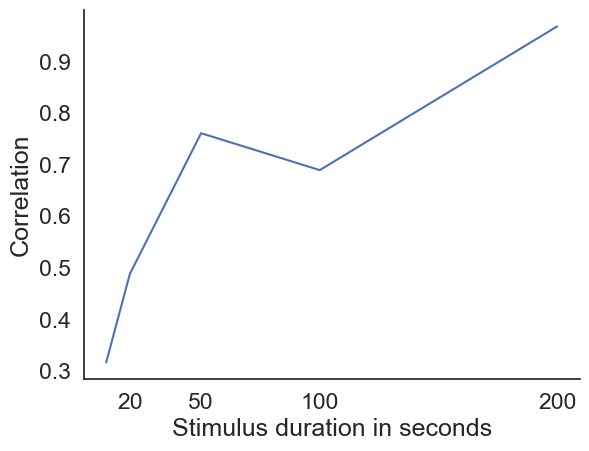

In [80]:
durations = [10., 20., 50., 100., 200.]

correlations = np.array([fit_poisson(duration=duration) for duration in durations])
plt.plot(durations, correlations)
plt.xlabel('Stimulus duration in seconds')
plt.xticks(durations[1:])
plt.ylabel('Correlation')

The correlation increased as the stimulus duration increases. It seems to not have flattened out yet by 200 seconds, so the estimator would probably benefit from a longer stimulus

### B

average spike rate: 0.67 spikes per second
average spike rate: 1.51 spikes per second
average spike rate: 4.33 spikes per second
average spike rate: 9.42 spikes per second
average spike rate: 19.35 spikes per second
average spike rate: 49.45 spikes per second


Text(0, 0.5, 'Correlation')

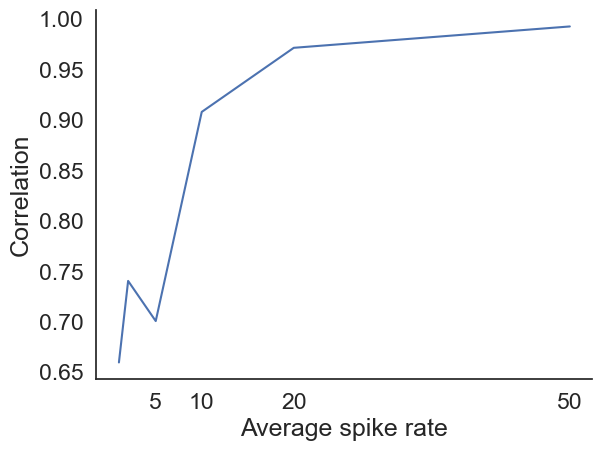

In [82]:
spike_rates = [1., 2., 5., 10., 20., 50.]

correlations = np.array([fit_poisson(duration=100, spike_rate=spike_rate) for spike_rate in spike_rates])
plt.plot(spike_rates, correlations)
plt.xlabel('Average spike rate')
plt.xticks(spike_rates[2:])
plt.ylabel('Correlation')

The correlation and thus the estimator accuracy increases as the average spike rate increases. This is probably because of the same reason that the correlation increases with stimulus duration: more spikes means more data for the estimator to fit on.